In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from fancyimpute import KNN
import warnings
warnings.filterwarnings('ignore')
from geopy.distance import great_circle
from geopy.distance import geodesic
from scipy.stats import chi2_contingency
import statsmodels.api as smapi
from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.externals import joblib

Using TensorFlow backend.


In [2]:
os.chdir("C:/Users/91888/OneDrive/Desktop/DataScience Project")

In [3]:
os.getcwd()

'C:\\Users\\91888\\OneDrive\\Desktop\\DataScience Project'

In [4]:
train = pd.read_csv("train_cab.csv",dtype ={'fare_amount':np.float64},na_values={'fare_amount':'430-'})
test = pd.read_csv("test.csv")
data=[train,test]
for i in data:
    i['pickup_datetime'] = pd.to_datetime(i['pickup_datetime'],errors='coerce')  #converting non numeric values to nan  

In [5]:
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [6]:
train.shape

(16067, 7)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16066 non-null datetime64[ns, UTC]
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 878.7 KB


In [8]:
test.head(5)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1


In [9]:
test.shape

(9914, 6)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null datetime64[ns, UTC]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 464.8 KB


In [11]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [12]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In [13]:
#Exploratory Data Analysis
#converting passeneger_count into categorical variable
cat_var =['passenger_count']
num_var =['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

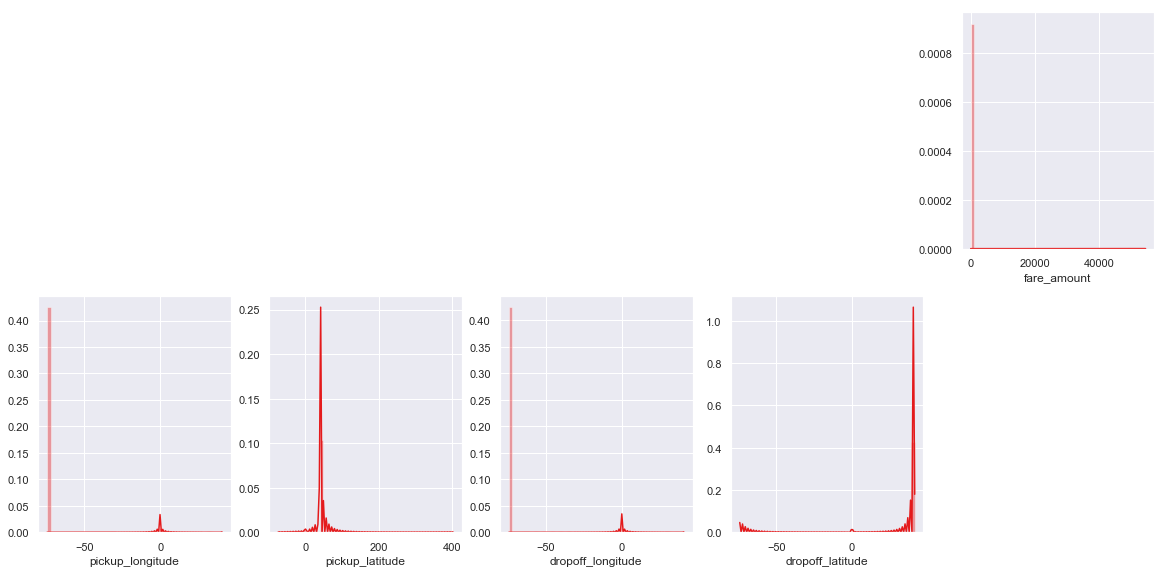

In [14]:
#setting up histogram plots for data visualization
sns.set(style='darkgrid',palette='Set1')
plt.figure(figsize=(20,20))
plt.subplot(455)
viewplot=sns.distplot(train['fare_amount'],bins=50)
plt.subplot(456)
viewplot=sns.distplot(train['pickup_longitude'],bins=50)
plt.subplot(457)
viewplot=sns.distplot(train['pickup_latitude'],bins=50)
plt.subplot(458)
viewplot=sns.distplot(train['dropoff_longitude'],bins=50)
plt.subplot(459)
viewplot=sns.distplot(train['dropoff_latitude'],bins=50)
plt.savefig('histogramvisualizationinitial.png')
plt.show()

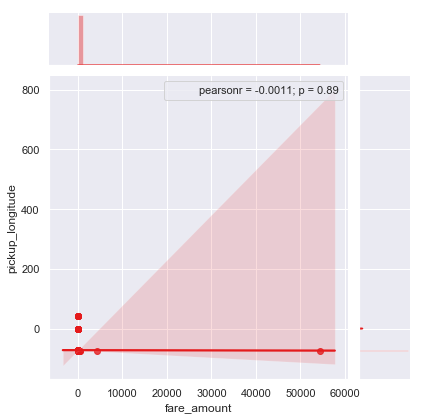

In [15]:
#Joint Plots for bivariate analysis
#

viewplot=sns.jointplot(x='fare_amount',y='pickup_longitude',data=train,kind='reg')   #reg = regression
viewplot.annotate(stats.pearsonr)
plt.savefig('jointplot_fare_amount_vs_pickup_longitude.png')
plt.show()

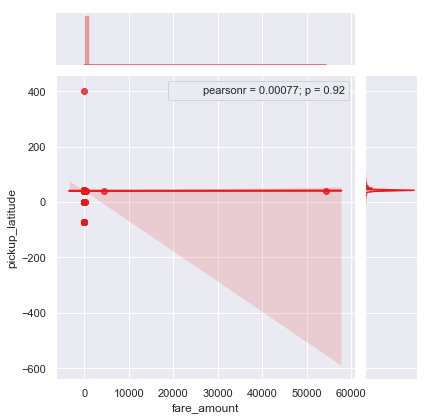

In [16]:
viewplot=sns.jointplot(x='fare_amount',y='pickup_latitude',data=train,kind='reg')
viewplot.annotate(stats.pearsonr)
plt.savefig('jointplot_fare_amount_vs_pickup_latitude.png')
plt.show()

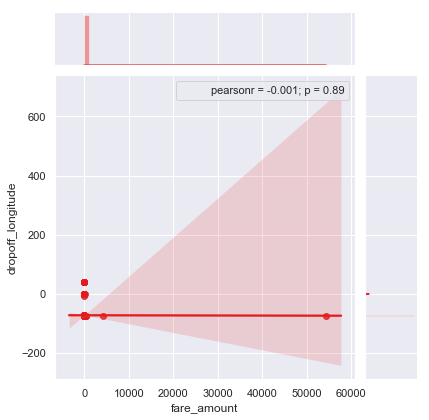

In [17]:
viewplot=sns.jointplot(x='fare_amount',y='dropoff_longitude',data=train,kind='reg')
viewplot.annotate(stats.pearsonr)
plt.savefig('jointplot_fare_amount_vs_dropoff_longitude.png')
plt.show()

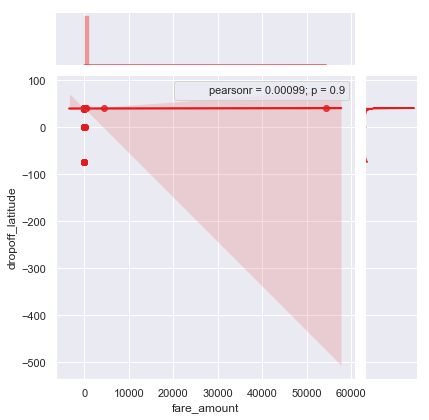

In [18]:
viewplot=sns.jointplot(x='fare_amount',y='dropoff_latitude',data=train,kind = 'reg')
viewplot.annotate(stats.pearsonr)
plt.savefig('jointplot_fare_amount_vs_dropoff_latitude.png')
plt.show()

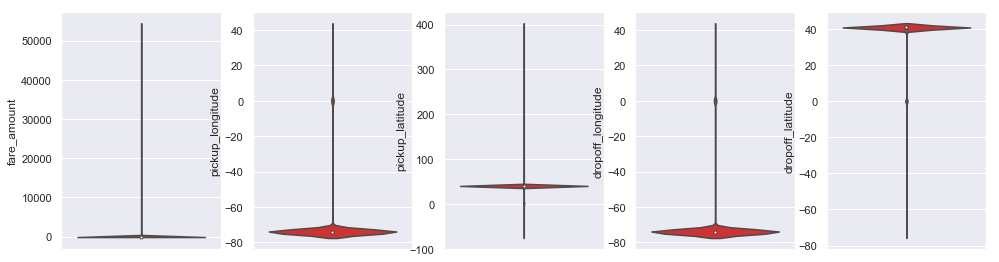

In [19]:
#Violin plots to see how the variables are spread out
plt.figure(figsize=(20,20))
plt.subplot(461)
viewplot=sns.violinplot(y ='fare_amount',data=train)
plt.subplot(462)
viewplot=sns.violinplot(y ='pickup_longitude',data=train)
plt.subplot(463)
viewplot=sns.violinplot(y ='pickup_latitude',data=train)
plt.subplot(464)
viewplot=sns.violinplot(y ='dropoff_longitude',data=train)
plt.subplot(465)
viewplot=sns.violinplot(y ='dropoff_latitude',data=train)
plt.savefig('violinplotinitial.png')
plt.show()

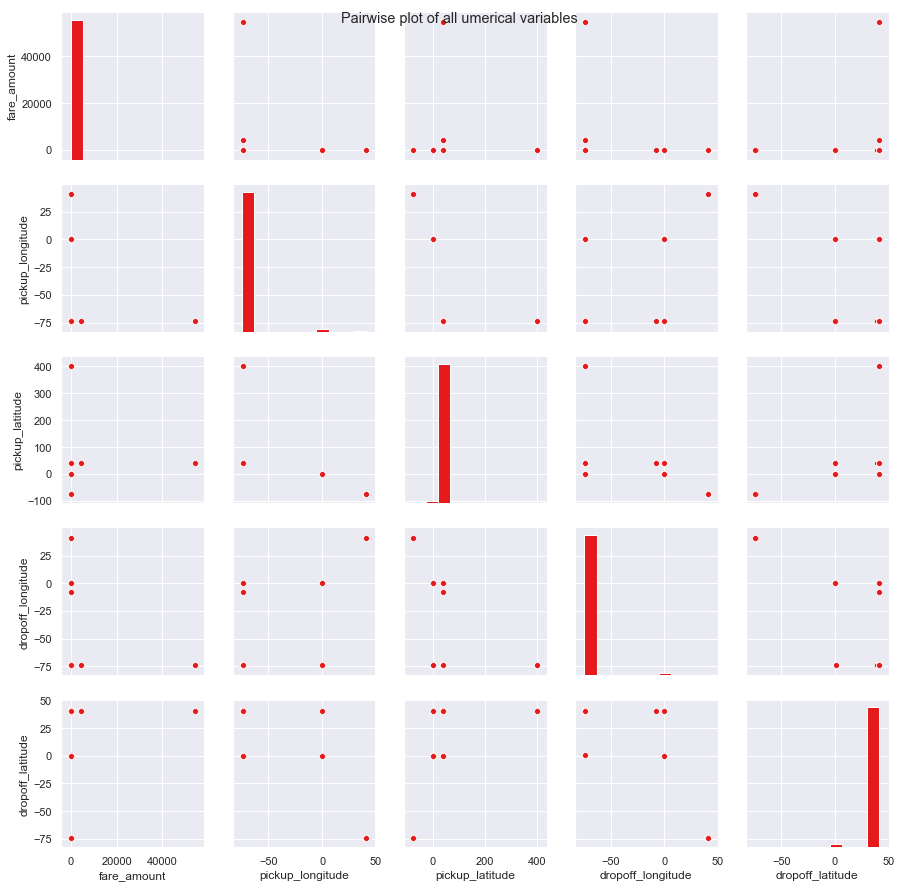

In [20]:
#pairplotting the all the numerical values
viewplot=sns.pairplot(data=train[num_var],kind = 'scatter',dropna = True)
viewplot.fig.suptitle('Pairwise plot of all umerical variables')
plt.savefig('Pairplotinitial.png')
plt.show()

In [21]:
#Remove variables which are not logicalcally correct. for ex, negative values of fare amount
sum(train['fare_amount']<1)

5

In [22]:
train[train['fare_amount']<1] #shows which vales of fare_amount are less than 1

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,-2.90,2010-03-09 23:37:10+00:00,-73.789450,40.643498,-73.788665,40.641952,1.0
2486,-2.50,2015-03-22 05:14:27+00:00,-74.000031,40.720631,-73.999809,40.720539,1.0
2780,0.01,2015-05-01 15:38:41+00:00,-73.939041,40.713963,-73.941673,40.713997,1.0
10002,0.00,2010-02-15 14:26:01+00:00,-73.987115,40.738808,-74.005911,40.713960,1.0
13032,-3.00,2013-08-30 08:57:10+00:00,-73.995062,40.740755,-73.995885,40.741357,4.0


In [23]:
train = train.drop(train[train['fare_amount']<1].index,axis = 0) #dropping values where fare_amount is less than 1

In [24]:
sum(train['fare_amount']<1)

0

In [25]:
#checking the valid passanger number in a ride
for i in range(6,11):
    print('passenger_count after'+ str(i)+'={}'.format(sum(train['passenger_count']>i)))

passenger_count after6=20
passenger_count after7=20
passenger_count after8=20
passenger_count after9=20
passenger_count after10=20


In [26]:
#total number of observations where the num of passangers is greater than 6 is invalid
sum(train['passenger_count']>6)

20

In [27]:
#total number of observations where the num of passangers is less than 1 is invalid
sum(train['passenger_count']<1)

58

In [28]:
#checking the unique variables in test data
test['passenger_count'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [29]:
#removing the values where the passenger_count value is less than 1 and greater than 6
train = train.drop(train[train['passenger_count']>6].index,axis = 0)
train = train.drop(train[train['passenger_count']<1].index,axis = 0)                         

In [30]:
sum(train['passenger_count']<1)

0

In [31]:
#lattitude and longitude values vary from -90 to 90 and -180 to 180.Any values above and below these values are illogical.So we need to remove them.
#checking values 
print('pickup_longitude above 180 ={}'.format(sum(train['pickup_longitude']>180)))
print('pickup_longitude below -180 ={}'.format(sum(train['pickup_longitude']<-180)))
print('pickup_latitude above 90 ={}'.format(sum(train['pickup_latitude']>90)))
print('pickup_latitude below -90 ={}'.format(sum(train['pickup_latitude']<-90)))
print('dropoff_longitude above 180 ={}'.format(sum(train['dropoff_longitude']>180)))
print('dropoff_longitude below -180 ={}'.format(sum(train['dropoff_longitude']<-180)))
print('dropoff_latitude above 90 ={}'.format(sum(train['dropoff_latitude']>90)))
print('dropoff_latitude below -90 ={}'.format(sum(train['dropoff_latitude']<-90)))

pickup_longitude above 180 =0
pickup_longitude below -180 =0
pickup_latitude above 90 =1
pickup_latitude below -90 =0
dropoff_longitude above 180 =0
dropoff_longitude below -180 =0
dropoff_latitude above 90 =0
dropoff_latitude below -90 =0


In [32]:
#removing the above value which doesn't fall in the ranges 
train = train.drop(train[train['pickup_latitude']>90].index,axis=0)

In [33]:
print('pickup_latitude above 90 ={}'.format(sum(train['pickup_latitude']>90)))

pickup_latitude above 90 =0


In [34]:
#checking if there are any values equal to 0
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    print(i,'equal to 0={}'.format(sum(train[i]==0)))

pickup_longitude equal to 0=311
pickup_latitude equal to 0=311
dropoff_longitude equal to 0=312
dropoff_latitude equal to 0=310


In [35]:
#we need to remove the above values
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    train = train.drop(train[train[i]==0].index,axis=0)

In [36]:
train.shape

(15661, 7)

In [37]:
df= train.copy()

In [38]:
#create dataframe with missing values
missing_val = pd.DataFrame(train.isnull().sum()) #isnull() shows the values that have no values in them
#reset index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,fare_amount,22
1,pickup_datetime,1
2,pickup_longitude,0
3,pickup_latitude,0
4,dropoff_longitude,0
5,dropoff_latitude,0
6,passenger_count,55


In [39]:
#since there are some missing values in the data, we will impute those values
#Renaming the variable 
missing_val = missing_val.rename(columns = {'index': 'Variables',0: 'Missing_Percentage'})
missing_val
#calculate percentage
missing_val['Missing_Percentage'] = (missing_val['Missing_Percentage']/len(train))*100
#decending order
missing_val = missing_val.sort_values('Missing_Percentage',ascending = False).reset_index(drop = True)
missing_val

,Variables,Missing_Percentage
0,passenger_count,0.351191
1,fare_amount,0.140476
2,pickup_datetime,0.006385
3,pickup_longitude,0.000000
4,pickup_latitude,0.000000
5,dropoff_longitude,0.000000
6,dropoff_latitude,0.000000


In [40]:
#chosing a random value to replace as NA
train['passenger_count'].loc[1000]

1.0

In [41]:
#replacing with na
train['passenger_count'].loc[1000]=np.nan
train['passenger_count'].loc[1000]

nan

In [42]:
#impute with mode
train['passenger_count'].fillna(train['passenger_count'].mode()[0]).loc[1000]

1.0

In [43]:
#the above method cant be used since the data will me more biased towards passanger_count=1 so we move on to fare_amount 
#chosing a random value to replace with nan
a = train['fare_amount'].loc[1000]
print('fare amount at loc=1000:{}'.format(a)) #acutal value at location 1000
#Replacing 1.0 with nan
train['fare_amount'].loc[1000] = np.nan
print('Value after replacing with nana:{}'.format(train['fare_amount'].loc[1000]))
#imputing with mean 
print('Value imputed with mean:{}'.format(train['fare_amount'].fillna(train['fare_amount'].mean()).loc[1000]))
#imputinh with median
print('Value imputed with median:{}'.format(train['fare_amount'].fillna(train['fare_amount'].median()).loc[1000]))

fare amount at loc=1000:7.0
Value after replacing with nana:nan
Value imputed with mean:15.118196060877201
Value imputed with median:8.5


In [44]:
train.std()   #standard deviation of all the variables

fare_amount          435.982171
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.266096
dtype: float64

In [45]:
columns=['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [46]:
#we have to separate pickup_datetime into a different dataframe and then merge with train in feature engineering step
pickup_datetime = pd.DataFrame(train['pickup_datetime'])

In [47]:
#imputing missing values with KNN
#using 19 rows which have a feature to fill each row's missing feature
train = pd.DataFrame(KNN(k=19).fit_transform(train.drop('pickup_datetime',axis=1)),columns = columns,index = train.index)    

Imputing row 1/15661 with 0 missing, elapsed time: 39.291
Imputing row 101/15661 with 0 missing, elapsed time: 39.359
Imputing row 201/15661 with 0 missing, elapsed time: 39.365
Imputing row 301/15661 with 0 missing, elapsed time: 39.366
Imputing row 401/15661 with 0 missing, elapsed time: 39.367
Imputing row 501/15661 with 0 missing, elapsed time: 39.370
Imputing row 601/15661 with 0 missing, elapsed time: 39.376
Imputing row 701/15661 with 0 missing, elapsed time: 39.380
Imputing row 801/15661 with 0 missing, elapsed time: 39.383
Imputing row 901/15661 with 0 missing, elapsed time: 39.389
Imputing row 1001/15661 with 0 missing, elapsed time: 39.391
Imputing row 1101/15661 with 0 missing, elapsed time: 39.393
Imputing row 1201/15661 with 0 missing, elapsed time: 39.393
Imputing row 1301/15661 with 0 missing, elapsed time: 39.394
Imputing row 1401/15661 with 0 missing, elapsed time: 39.396
Imputing row 1501/15661 with 0 missing, elapsed time: 39.397
Imputing row 1601/15661 with 0 missi

In [48]:
train['fare_amount'].loc[1000]

7.369801193170853

In [49]:
train.std()

fare_amount          435.661995
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.264138
dtype: float64

In [50]:
train.loc[1000]

fare_amount           7.369801
pickup_longitude    -73.995420
pickup_latitude      40.759662
dropoff_longitude   -73.987607
dropoff_latitude     40.751247
passenger_count       2.544158
Name: 1000, dtype: float64

In [51]:
train['passenger_count'].head()

0    1.0
1    1.0
2    2.0
3    1.0
4    1.0
Name: passenger_count, dtype: float64

In [52]:
train['passenger_count']= train['passenger_count'].astype('int')

In [53]:
train.std()

fare_amount          435.661995
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.264322
dtype: float64

In [54]:
train['passenger_count'].unique()

array([1, 2, 3, 6, 5, 4], dtype=int64)

In [55]:
train['passenger_count'] = train['passenger_count'].round().astype('object').astype('category',ordered=True)

In [56]:
train.loc[1000]

fare_amount           7.3698
pickup_longitude    -73.9954
pickup_latitude      40.7597
dropoff_longitude   -73.9876
dropoff_latitude     40.7512
passenger_count            2
Name: 1000, dtype: object

In [57]:
#missing value in pickup_datetime
pickup_datetime.head()

,pickup_datetime
0,2009-06-15 17:26:21+00:00
1,2010-01-05 16:52:16+00:00
2,2011-08-18 00:35:00+00:00
3,2012-04-21 04:30:42+00:00
4,2010-03-09 07:51:00+00:00


In [58]:
#creating dataframe with missing percentage from pickup_datetime
missing_val = pd.DataFrame(pickup_datetime.isnull()).sum()
#Reset Index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,pickup_datetime,1


In [59]:
pickup_datetime.shape

(15661, 1)

In [60]:
train.shape

(15661, 6)

In [61]:
df1= train.copy()
train= df1.copy()

In [62]:
train['passenger_count'].describe()

count     15661
unique        6
top           1
freq      11056
Name: passenger_count, dtype: int64

In [63]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,15.110669,-73.911514,40.689712,-73.906315,40.687655
std,435.661995,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.500000,-73.982049,40.753300,-73.980555,40.754242
75%,12.500000,-73.968080,40.767805,-73.965360,40.768312
max,54343.000000,40.766125,41.366138,40.802437,41.366138


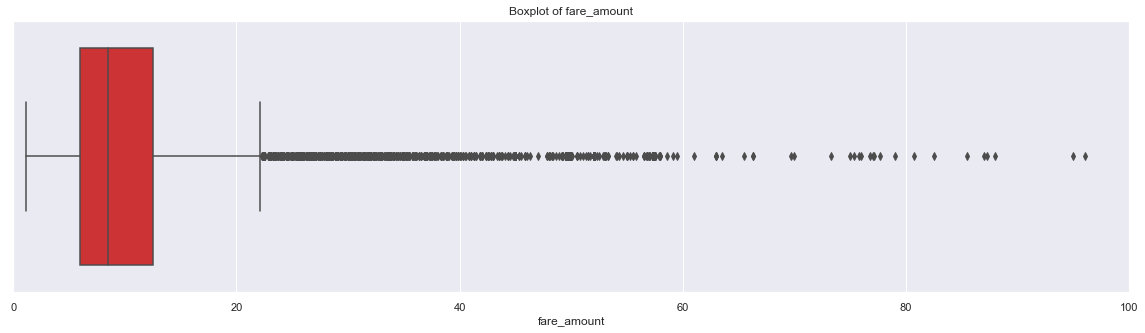

In [64]:
#Outlier Analysis
#We Will do Outlier Analysis only on Fare_amount for now
plt.figure(figsize=(20,5))
plt.xlim(0,100)
sns.boxplot(x=train['fare_amount'],data=train,orient ='h')
plt.title('Boxplot of fare_amount')
plt.savefig('Boxplot of fare_amount.png')
plt.show()

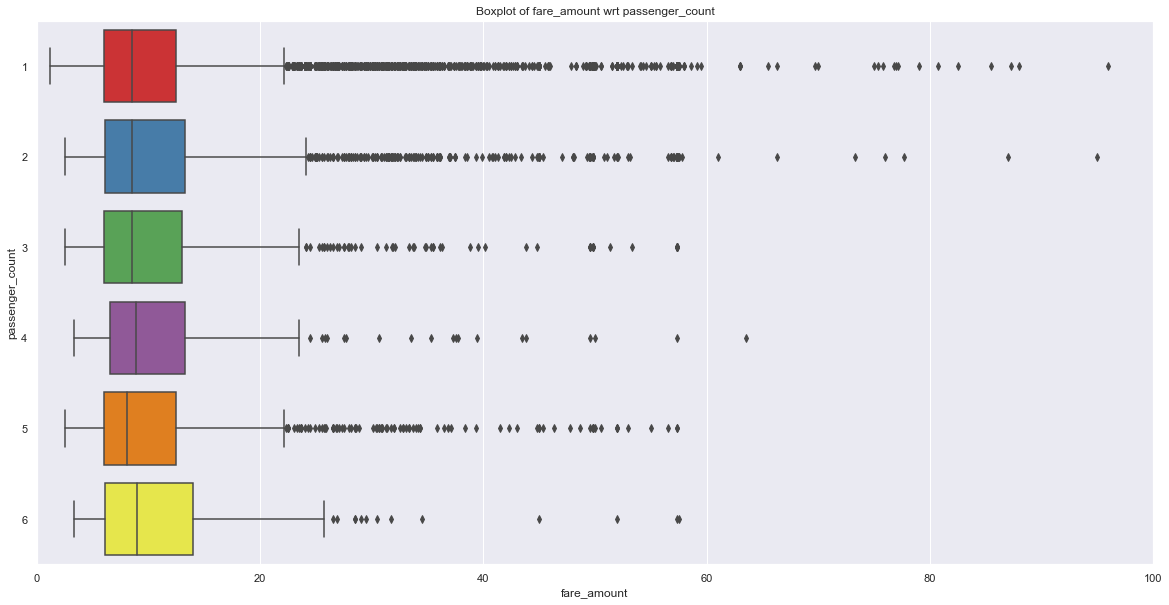

In [65]:
#bivariate boxplots for numerical vs categorical variables
plt.figure(figsize=(20,10))
plt.xlim(0,100)
viewplot=sns.boxplot(x=train['fare_amount'],y=train['passenger_count'],data=train,orient='h')
plt.title('Boxplot of fare_amount wrt passenger_count')
plt.savefig('Boxplot of fare_amount wrt passenger_count.png')
plt.show()

In [66]:
#There are a lot of outliers which has to be taken care of
#calculating outlier locations and replacing them with NA
def removeoutlier(out):
#Extract Upper and lower Quartiles    
    q75,q25 = np.percentile(train[out],[75,25])
    print(q75,q25)
#calculating interquartile range
    iqr=q75 - q25
#calculating inner and outer range
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)  
    print(minimum,maximum)
#replace with NA
    train.loc[train[out] < minimum,out] = np.nan
    train.loc[train[out] > maximum,out] = np.nan

In [67]:
removeoutlier('fare_amount')

12.5 6.0
-3.75 22.25


In [68]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,1359
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [69]:
train.std()

fare_amount          4.136102
pickup_longitude     2.659050
pickup_latitude      2.613305
dropoff_longitude    2.710835
dropoff_latitude     2.632400
passenger_count      1.264322
dtype: float64

In [70]:
#Imputing missing values using KNN
train = pd.DataFrame(KNN(k=3).fit_transform(train),columns = train.columns, index = train.index)

Imputing row 1/15661 with 0 missing, elapsed time: 30.340
Imputing row 101/15661 with 0 missing, elapsed time: 30.341
Imputing row 201/15661 with 0 missing, elapsed time: 30.342
Imputing row 301/15661 with 1 missing, elapsed time: 30.343
Imputing row 401/15661 with 0 missing, elapsed time: 30.344
Imputing row 501/15661 with 0 missing, elapsed time: 30.345
Imputing row 601/15661 with 1 missing, elapsed time: 30.346
Imputing row 701/15661 with 0 missing, elapsed time: 30.347
Imputing row 801/15661 with 0 missing, elapsed time: 30.349
Imputing row 901/15661 with 0 missing, elapsed time: 30.350
Imputing row 1001/15661 with 0 missing, elapsed time: 30.351
Imputing row 1101/15661 with 1 missing, elapsed time: 30.352
Imputing row 1201/15661 with 0 missing, elapsed time: 30.353
Imputing row 1301/15661 with 0 missing, elapsed time: 30.353
Imputing row 1401/15661 with 0 missing, elapsed time: 30.355
Imputing row 1501/15661 with 0 missing, elapsed time: 30.356
Imputing row 1601/15661 with 0 missi

In [71]:
train.std()

fare_amount          4.476970
pickup_longitude     2.659050
pickup_latitude      2.613305
dropoff_longitude    2.710835
dropoff_latitude     2.632400
passenger_count      1.264322
dtype: float64

In [72]:
train['passenger_count'].describe()

count    15661.000000
mean         1.649192
std          1.264322
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

In [73]:
train['passenger_count']=train['passenger_count'].astype('int').round().astype('category')

In [74]:
train.describe()    

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,9.404603,-73.911514,40.689712,-73.906315,40.687655
std,4.476970,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.200000,-73.982049,40.753300,-73.980555,40.754242
75%,11.800000,-73.968080,40.767805,-73.965360,40.768312
max,22.100000,40.766125,41.366138,40.802437,41.366138


In [75]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [76]:
df2=train.copy()


In [77]:
train.shape

(15661, 6)

In [78]:
#Feature Engineering
#for timestamp variable
#Two dataframes(pickup_datetime and train) need to be joined and new features need to be derived from pickup_datetime variable
#new features will be year , month, day_of_week, hour

train = pd.merge(pickup_datetime,train,right_index = True,left_index = True)
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [79]:
train.shape

(15661, 7)

In [80]:
train=train.reset_index(drop=True)

In [81]:
pd.DataFrame(train.isna().sum())

,0
pickup_datetime,1
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [82]:
#we need to drop the missing value
train=train.dropna()

In [83]:
train.isna().sum() #we can see that the missing value has been dropped from pickup_datetime

pickup_datetime      0
fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [84]:
#adding new features. we do this because this variable has multiple attributes embedded in it. We can have alook at how the values change with canging year or month. This makes our prediction more accurate.We will be dropping these values later.
data = [train,test]
for i in data:
    i["year"] = i["pickup_datetime"].apply(lambda row: row.year)
    i["month"] = i["pickup_datetime"].apply(lambda row: row.month)
    i["day_of_week"] = i["pickup_datetime"].apply(lambda row: row.dayofweek)
    i["hour"] = i["pickup_datetime"].apply(lambda row: row.hour)

In [85]:
data

[                pickup_datetime  fare_amount  pickup_longitude  \
 0     2009-06-15 17:26:21+00:00     4.500000        -73.844311   
 1     2010-01-05 16:52:16+00:00    16.900000        -74.016048   
 2     2011-08-18 00:35:00+00:00     5.700000        -73.982738   
 3     2012-04-21 04:30:42+00:00     7.700000        -73.987130   
 4     2010-03-09 07:51:00+00:00     5.300000        -73.968095   
 5     2011-01-06 09:50:45+00:00    12.100000        -74.000964   
 6     2012-11-20 20:35:00+00:00     7.500000        -73.980002   
 7     2012-01-04 17:22:00+00:00    16.500000        -73.951300   
 8     2012-12-03 13:10:00+00:00     6.011615        -74.006462   
 9     2009-09-02 01:11:00+00:00     8.900000        -73.980658   
 10    2012-04-08 07:30:50+00:00     5.300000        -73.996335   
 11    2009-11-06 01:04:03+00:00     4.100000        -73.991601   
 12    2013-07-02 19:54:00+00:00     7.000000        -74.005360   
 13    2011-04-05 17:11:05+00:00     7.700000        -74.00182

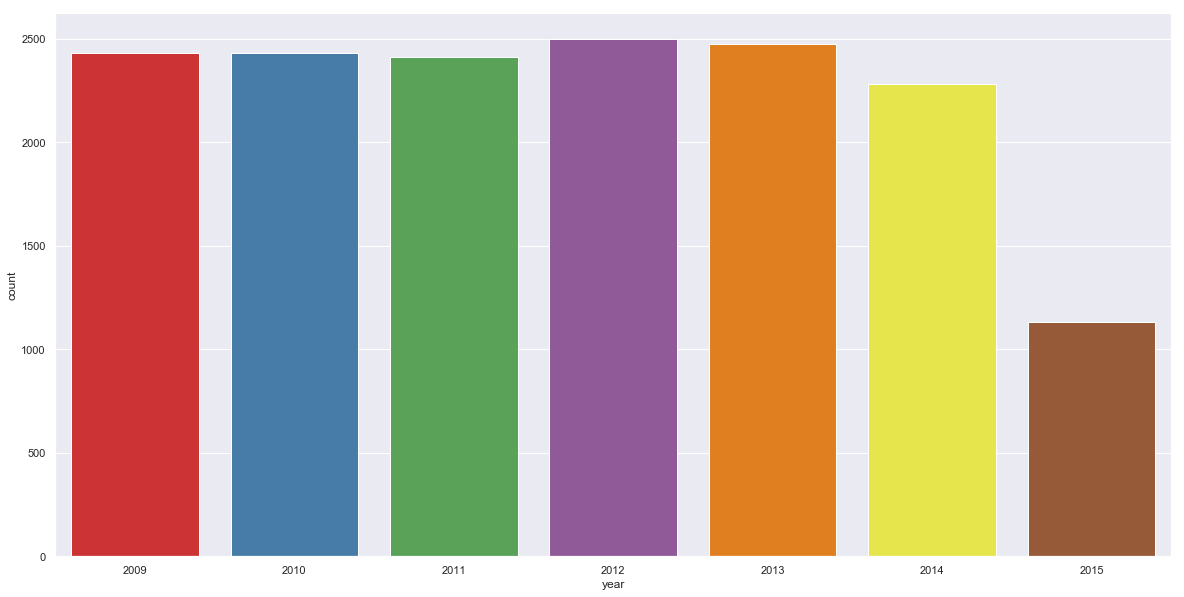

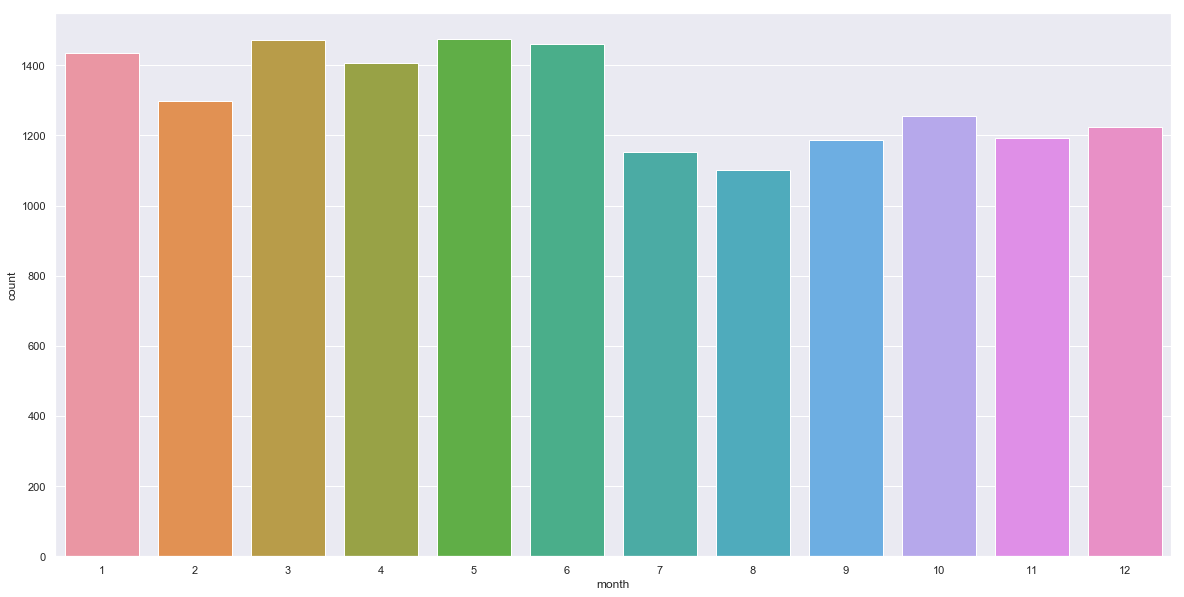

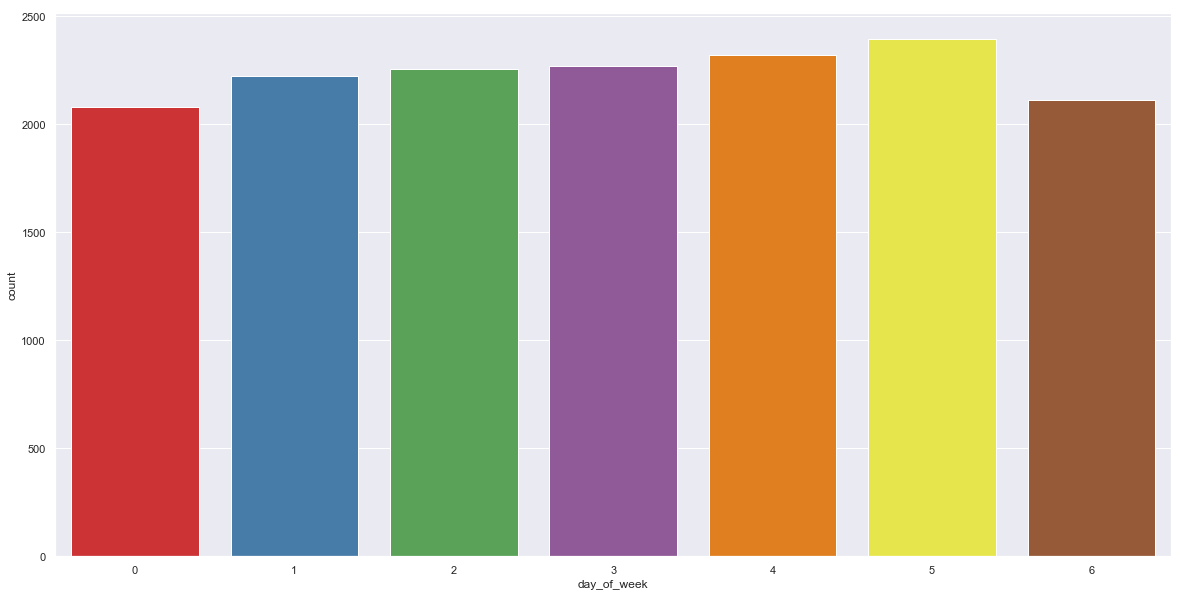

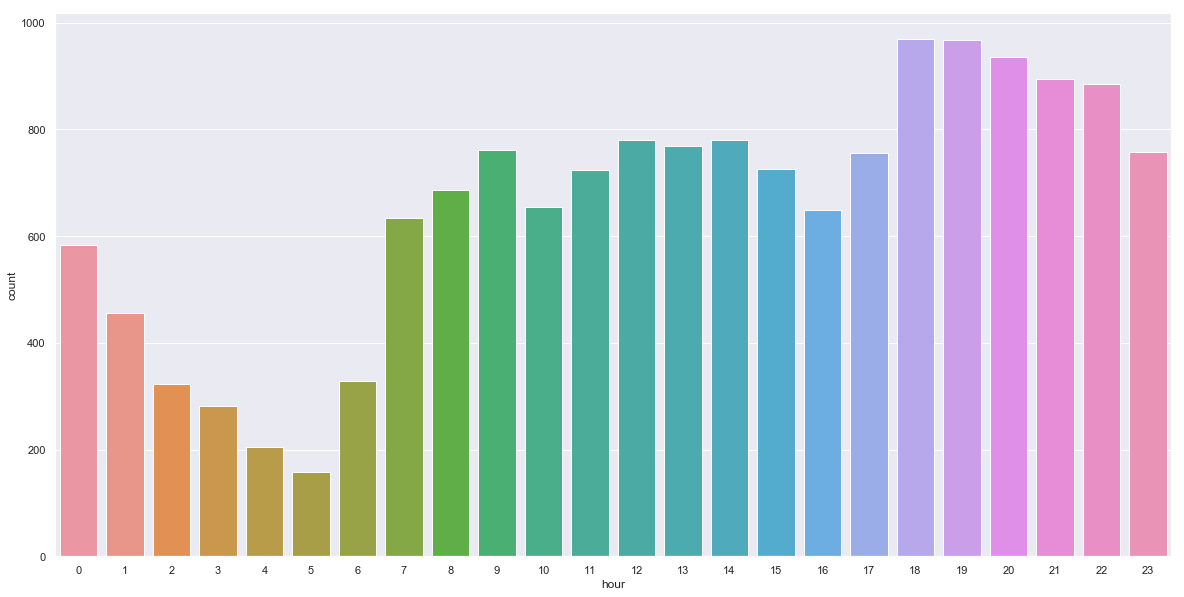

In [86]:
plt.figure(figsize=(20,10))
sns.countplot(train['year'])
plt.savefig('yearcolumn.png')

plt.figure(figsize=(20,10))
sns.countplot(train['month'])
plt.savefig('monthcolumn.png')

plt.figure(figsize=(20,10))
sns.countplot(train['day_of_week'])
plt.savefig('dayofweekcolumn.png')

plt.figure(figsize=(20,10))
sns.countplot(train['hour'])
plt.savefig('hourcolumn.png')

In [87]:
#more features need to be derived like sessions in a day, seasons, weekend/weekday and for these we will be using months,day_of_week,hour 
#for sessions in a day
def f(x):
    if (x>=5) and (x<=11):
        return 'morning'
    elif (x>=12) and (x<=16):
        return 'afternoon'
    elif (x>=17) and (x<=20):
        return 'evening'
    elif (x>=21) and (x<=23):
        return 'night_PM'
    elif (x>=0) and (x<=4):
        return 'night_AM'

In [88]:
#for seasons in a year
def g(x):
    if (x>=3) and (x<=5):
        return 'spring'
    elif (x>=6) and (x<=8):
        return 'summer'
    elif (x>=9) and (x<=11):
        return 'fall'
    elif (x>=12)|(x<=2):
        return 'winter'

In [89]:
#for weekend/weekday
def h(x):
    if (x>=0) and (x<=4):
        return 'weekday'
    elif (x>=5) and (x<=6):
        return 'weekend'

In [90]:
train['session'] = train['hour'].apply(f)
test['session'] = test['hour'].apply(f)

In [91]:
train['seasons'] = train['month'].apply(g)
test['seasons'] = test['month'].apply(g)

In [92]:
train['week'] = train['day_of_week'].apply(h)
test['week'] = test['day_of_week'].apply(h)

In [93]:
train.shape,test.shape

((15660, 14), (9914, 13))

In [94]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,session,seasons,week
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,afternoon,winter,weekday
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,afternoon,winter,weekday
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,morning,fall,weekend
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,night_PM,winter,weekend
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,night_PM,winter,weekend


In [95]:
#Feature Engineering for passenger_count variable
#we will create dummy variables in both train and test dataset because models in scikit learn require numerical input.If dataset contains categorical variables then we have to encode them.We will use one-hot-encoding for them

temp = pd.get_dummies(train['passenger_count'], prefix = 'passenger_count')
train = train.join(temp)
temp = pd.get_dummies(test['passenger_count'], prefix = 'passenger_count')
test = test.join(temp)
temp = pd.get_dummies(train['seasons'], prefix = 'seasons')
train = train.join(temp)
temp = pd.get_dummies(test['seasons'], prefix = 'seasons')
test = test.join(temp)
temp = pd.get_dummies(train['week'], prefix = 'week')
train = train.join(temp)
temp = pd.get_dummies(test['week'], prefix = 'week')
test = test.join(temp)
temp = pd.get_dummies(train['session'], prefix = 'session')
train = train.join(temp)
temp = pd.get_dummies(test['session'], prefix = 'session')
test = test.join(temp)
temp = pd.get_dummies(train['year'], prefix = 'year')
train = train.join(temp)
temp = pd.get_dummies(test['year'], prefix = 'year')
test = test.join(temp)

In [96]:
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_morning,session_night_AM,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,...,0,0,0,1,0,0,0,0,0,0
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,0,0,1,0,0,0,0,0
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,0,1,0,0,0,1,0,0,0,0
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,0,1,0,0,0,0,1,0,0,0
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,1,0,0,0,1,0,0,0,0,0


In [97]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_morning,session_night_AM,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,1,0,0,0,0,1,0,0,0,0
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0


In [98]:
train.columns

Index(['pickup_datetime', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'seasons_fall', 'seasons_spring', 'seasons_summer', 'seasons_winter',
       'week_weekday', 'week_weekend', 'session_afternoon', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2009',
       'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014',
       'year_2015'],
      dtype='object')

In [99]:
#To avoid 'Dummy Variable Trap' we need to drop one column from each of the one-hot-encoded variables from both train and test
train = train.drop(['passenger_count_1','seasons_fall','week_weekday','session_afternoon','year_2009'],axis=1)
test = test.drop(['passenger_count_1','seasons_fall','week_weekday','session_afternoon','year_2009'],axis=1)

In [100]:
#Feature Engineerig for latitude and longitude variable
#we have to find the distace travelled by the cab from pickup to dropoff location using Haversine and Vincenty method
data = [train,test]
for i in data:
    i['great_circle']=i.apply(lambda x: great_circle((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'], x['dropoff_longitude'])).miles,axis=1)
    i['geodesic']=i.apply(lambda x: great_circle((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'], x['dropoff_longitude'])).miles,axis=1)

In [101]:
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,...,0,0,0,0,0,0,0,0,0.640488,0.640488
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,1,0,0,0,0,0,5.250677,5.250677
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,1,0,0,1,0,0,0,0,0.863412,0.863412
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,1,0,0,0,1,0,0,0,1.739388,1.739388
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,0,0,1,0,0,0,0,0,1.242220,1.242220


In [102]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,1,1.443609,1.443609
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,1,1.507047,1.507047
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,0,0,0,1,0,0,0,0,0.384398,0.384398
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,0,1,0,0,1,0,0,0,1.218531,1.218531
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,0,1,0,0,1,0,0,0,3.347519,3.347519


In [103]:
#According to logic , Vincenty is more accurate than Haversine so we have to drop 'great_circle' variable. We also have to drop the variables which were used to feature engineer as they are in effective at this point.
train = train.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week','great_circle'], axis = 1)
test = test.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week','great_circle'],axis = 1)

In [104]:
train.shape, test.shape

((15660, 21), (9914, 20))

In [105]:
train.head()

,fare_amount,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,seasons_spring,seasons_summer,seasons_winter,week_weekend,...,session_morning,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,4.5,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.640488
1,16.9,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,5.250677
2,5.7,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0.863412
3,7.7,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1.739388
4,5.3,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1.242220


In [106]:
test.head()

,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,seasons_spring,seasons_summer,seasons_winter,week_weekend,session_evening,session_morning,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1.443609
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1.507047
2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0.384398
3,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1.218531
4,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,3.347519


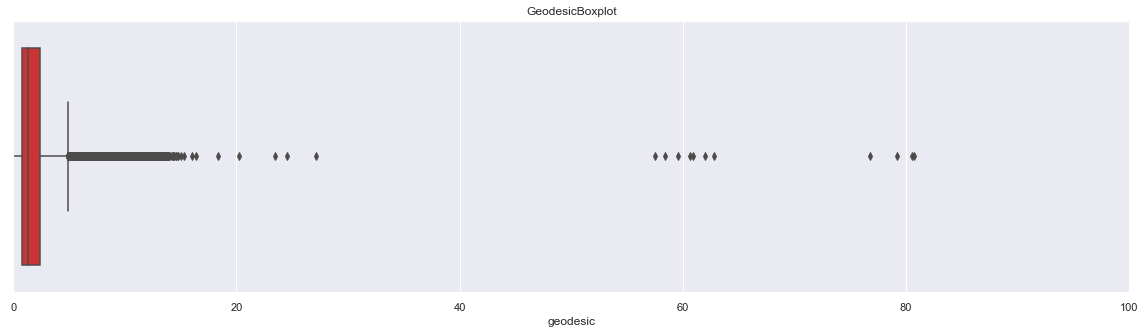

In [107]:
#Boxplot of ‘geodesic’ for range 0 to 100 miles 
plt.figure(figsize=(20,5))
plt.xlim(0,100)
sns.boxplot(x=train['geodesic'],data=train,orient='h')
plt.title('GeodesicBoxplot')
plt.savefig('GeodesicBoxplot.png')
plt.show()

In [108]:
removeoutlier('geodesic')

2.4263560743500054 0.7813049079548721
-1.686271841637828 4.893932823942706


In [109]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,0
passenger_count_2,0
passenger_count_3,0
passenger_count_4,0
passenger_count_5,0
passenger_count_6,0
seasons_spring,0
seasons_summer,0
seasons_winter,0
week_weekend,0


In [110]:
#imputing missing values with KNN
train = pd.DataFrame(KNN(k=3).fit_transform(train),columns = train.columns,index= train.index)

Imputing row 1/15660 with 0 missing, elapsed time: 43.883
Imputing row 101/15660 with 0 missing, elapsed time: 43.973
Imputing row 201/15660 with 0 missing, elapsed time: 43.977
Imputing row 301/15660 with 1 missing, elapsed time: 43.980
Imputing row 401/15660 with 0 missing, elapsed time: 43.982
Imputing row 501/15660 with 0 missing, elapsed time: 43.986
Imputing row 601/15660 with 1 missing, elapsed time: 43.988
Imputing row 701/15660 with 0 missing, elapsed time: 43.991
Imputing row 801/15660 with 0 missing, elapsed time: 43.994
Imputing row 901/15660 with 0 missing, elapsed time: 43.995
Imputing row 1001/15660 with 0 missing, elapsed time: 43.997
Imputing row 1101/15660 with 1 missing, elapsed time: 43.998
Imputing row 1201/15660 with 0 missing, elapsed time: 44.000
Imputing row 1301/15660 with 0 missing, elapsed time: 44.002
Imputing row 1401/15660 with 0 missing, elapsed time: 44.004
Imputing row 1501/15660 with 0 missing, elapsed time: 44.005
Imputing row 1601/15660 with 0 missi

In [111]:
train.columns

Index(['fare_amount', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'seasons_spring', 'seasons_summer', 'seasons_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [112]:
#Correlation Analysis. It is done to see if the variables are correlated to each other in any way.If values are correlated it would produce bias in our models.
cat_var=['passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'seasons_spring', 'seasons_summer', 'seasons_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015',]
num_var=['fare_amount','geodesic']

#converting to categorical variable
train[cat_var]=train[cat_var].apply(lambda x: x.astype('category')) 
test[cat_var]=test[cat_var].apply(lambda x: x.astype('category'))


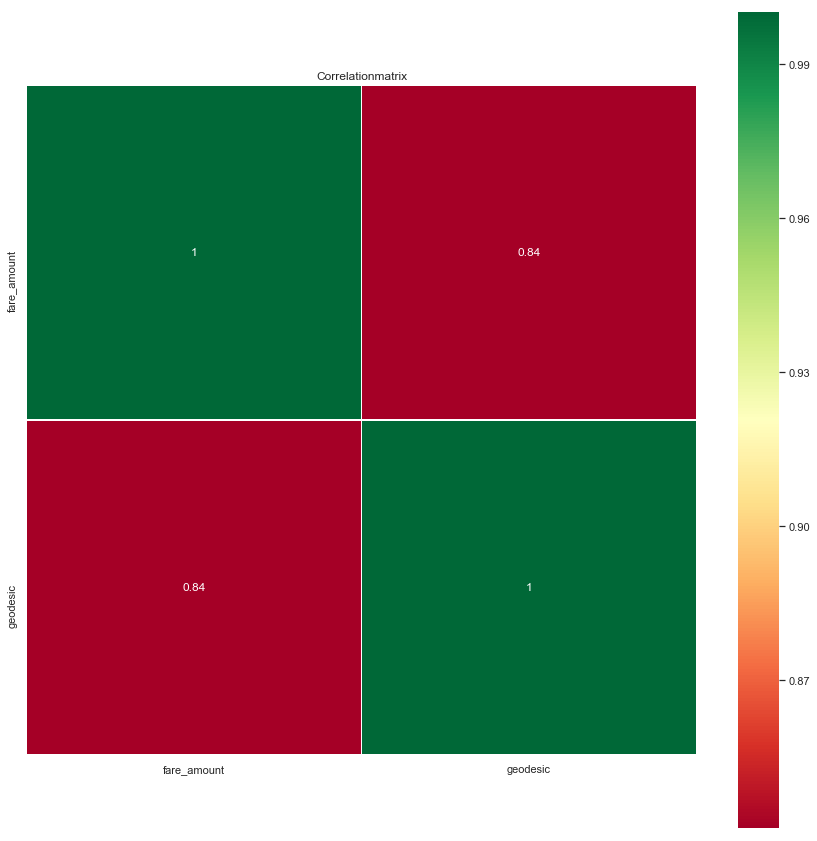

In [113]:
#heatmap using correlation matrix
plt.figure(figsize=(15,15))
viewplot=sns.heatmap(train[num_var].corr(),square = True, cmap='RdYlGn',linewidths=0.5,linecolor='w',annot=True)                              
plt.title('Correlationmatrix')
plt.savefig('Correlationmatrix.png')
plt.show()

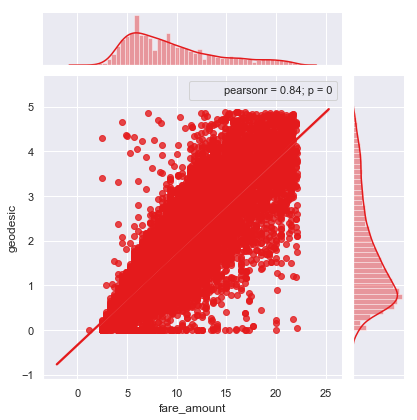

In [114]:
#lets look at a joint plot for the same 
viewplot=sns.jointplot(x='fare_amount',y='geodesic',data=train,kind='reg')
viewplot.annotate(stats.pearsonr)
plt.savefig('joint plot to see correlation between fare_amount and geodesic')
plt.show()

In [115]:
#Chi-Square test of independence for categorical variables
#If P value is less than 0.05 then we reject null hypothesis and the two variables are dependent
#If p value is more than 0.05 then we accept null hypothesis and the two variables are independent
#The variable whose whose p value is greater than 0.05 with other variables will be kept and the variable whose pvalue is less than 0.05 will be removed 
#creating a loop for chi square values
for i in cat_var:
    for j in cat_var:
        if(i != j):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(train[i],train[j]))
            if(p < 0.05):
                print(i,"and",j,"are dependent on each other with",p,'----Remove')
            else:
                print(i,"and",j,"are independent on each other with",p,'----Keep')

passenger_count_2 and passenger_count_3 are dependent on each other with 1.7121597150859386e-27 ----Remove
passenger_count_2 and passenger_count_4 are dependent on each other with 1.158785630549477e-13 ----Remove
passenger_count_2 and passenger_count_5 are dependent on each other with 1.02944814727332e-42 ----Remove
passenger_count_2 and passenger_count_6 are dependent on each other with 1.0340832329142975e-12 ----Remove
passenger_count_2 and seasons_spring are independent on each other with 0.983869902597337 ----Keep
passenger_count_2 and seasons_summer are dependent on each other with 0.024589215954971648 ----Remove
passenger_count_2 and seasons_winter are independent on each other with 0.520383954383566 ----Keep
passenger_count_2 and week_weekend are dependent on each other with 4.754147207990872e-11 ----Remove
passenger_count_2 and session_evening are dependent on each other with 0.015102648573757937 ----Remove
passenger_count_2 and session_morning are dependent on each other with 

seasons_spring and passenger_count_4 are independent on each other with 0.1852585488275776 ----Keep
seasons_spring and passenger_count_5 are dependent on each other with 0.03952059871407807 ----Remove
seasons_spring and passenger_count_6 are independent on each other with 0.9148172621932616 ----Keep
seasons_spring and seasons_summer are dependent on each other with 0.0 ----Remove
seasons_spring and seasons_winter are dependent on each other with 0.0 ----Remove
seasons_spring and week_weekend are independent on each other with 0.7961003257905971 ----Keep
seasons_spring and session_evening are independent on each other with 0.814055875892082 ----Keep
seasons_spring and session_morning are independent on each other with 0.056579031369672135 ----Keep
seasons_spring and session_night_AM are independent on each other with 0.5918306289650044 ----Keep
seasons_spring and session_night_PM are independent on each other with 0.6544364941549473 ----Keep
seasons_spring and year_2010 are independent 

session_morning and passenger_count_4 are dependent on each other with 5.1642593744268186e-05 ----Remove
session_morning and passenger_count_5 are independent on each other with 0.8399423948957928 ----Keep
session_morning and passenger_count_6 are independent on each other with 0.6784441752716932 ----Keep
session_morning and seasons_spring are independent on each other with 0.056579031369672135 ----Keep
session_morning and seasons_summer are independent on each other with 0.8501174445937183 ----Keep
session_morning and seasons_winter are independent on each other with 0.8265071653243 ----Keep
session_morning and week_weekend are dependent on each other with 1.5044462337151303e-38 ----Remove
session_morning and session_evening are dependent on each other with 0.0 ----Remove
session_morning and session_night_AM are dependent on each other with 3.155991736009208e-155 ----Remove
session_morning and session_night_PM are dependent on each other with 2.9392958051513584e-223 ----Remove
session

year_2011 and year_2014 are dependent on each other with 2.2975565160205107e-107 ----Remove
year_2011 and year_2015 are dependent on each other with 4.938744696016752e-50 ----Remove
year_2012 and passenger_count_2 are independent on each other with 0.9098624729471089 ----Keep
year_2012 and passenger_count_3 are independent on each other with 0.6379575026311326 ----Keep
year_2012 and passenger_count_4 are independent on each other with 0.8273401138397842 ----Keep
year_2012 and passenger_count_5 are independent on each other with 0.2212520437304136 ----Keep
year_2012 and passenger_count_6 are dependent on each other with 0.03382702478573806 ----Remove
year_2012 and seasons_spring are dependent on each other with 0.000816210062254562 ----Remove
year_2012 and seasons_summer are dependent on each other with 0.0009517353086692014 ----Remove
year_2012 and seasons_winter are independent on each other with 0.36911913812354513 ----Keep
year_2012 and week_weekend are independent on each other wit

In [116]:
train.columns

Index(['fare_amount', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'seasons_spring', 'seasons_summer', 'seasons_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [117]:
#ANOVA 
model = ols('fare_amount ~ C(passenger_count_2)+C(passenger_count_3)+C(passenger_count_4)+C(passenger_count_5)+C(passenger_count_6)+C(seasons_spring)+C(seasons_summer)+C(seasons_winter)+C(week_weekend)+C(session_night_AM)+C(session_night_PM)+C(session_evening)+C(session_morning)+C(year_2010)+C(year_2011)+C(year_2012)+C(year_2013)+C(year_2014)+C(year_2015)',data=train).fit()
                
aov_table = smapi.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(passenger_count_2),1.0,10.568728,10.568728,0.545736,4.600765e-01
C(passenger_count_3),1.0,17.059092,17.059092,0.880877,3.479760e-01
C(passenger_count_4),1.0,63.933288,63.933288,3.301312,6.924368e-02
C(passenger_count_5),1.0,21.286924,21.286924,1.099189,2.944603e-01
C(passenger_count_6),1.0,145.816804,145.816804,7.529518,6.076534e-03
C(seasons_spring),1.0,28.945378,28.945378,1.494648,2.215152e-01
C(seasons_summer),1.0,26.849975,26.849975,1.386448,2.390238e-01
C(seasons_winter),1.0,481.677256,481.677256,24.872287,6.191324e-07
C(week_weekend),1.0,130.826572,130.826572,6.755470,9.354849e-03
C(session_night_AM),1.0,2130.002751,2130.002751,109.986594,1.200118e-25


In [118]:
#Null Hypothesis is rejected because every value has p value less than 0.05

In [119]:
#Multicollinearity Test
#VIF is always greater than 1
#VIF = 1 not correlated to any values 
#VIF is between 1 and 5 . Moderately correlated
#VIF is above 5 = highly correlated 

# calculating VIF for each individual Predictors
outcome, predictors = dmatrices('fare_amount ~ geodesic+passenger_count_2+passenger_count_3+passenger_count_4+passenger_count_5+passenger_count_6+seasons_spring+seasons_summer+seasons_winter+week_weekend+session_night_AM+session_night_PM+session_evening+session_morning+year_2010+year_2011+year_2012+year_2013+year_2014+year_2015',train, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

,VIF,features
0,15.267912,Intercept
1,1.040707,passenger_count_2[T.1.0]
2,1.019515,passenger_count_3[T.1.0]
3,1.011841,passenger_count_4[T.1.0]
4,1.024996,passenger_count_5[T.1.0]
5,1.017210,passenger_count_6[T.1.0]
6,1.642247,seasons_spring[T.1.0]
7,1.552396,seasons_summer[T.1.0]
8,1.587593,seasons_winter[T.1.0]
9,1.050818,week_weekend[T.1.0]


In [120]:
#Multicolliearity seems to be minimal

In [121]:
#Feature Scaling
train[num_var].var()

fare_amount    20.044259
geodesic        1.232677
dtype: float64

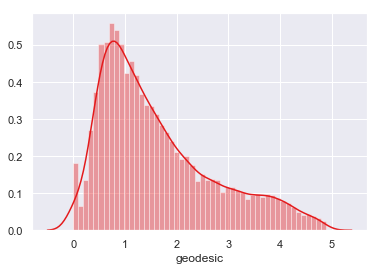

In [122]:
#Distplot
#it is done to see the data distribution(if the data is normalized or not

sns.distplot(train['geodesic'],bins=50)  #it is done to see the data distribution(if the data is normalized or not
plt.savefig('distplot for geodesic before normalization.png') 

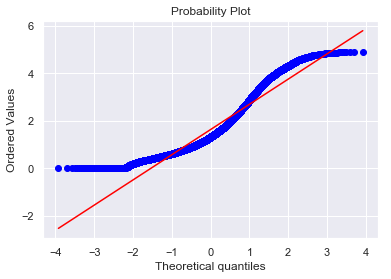

In [123]:
#Probplot or QQ Plot. this is also done to see the normalization 

plt.figure()
stats.probplot(train['geodesic'],dist='norm',fit=True,plot=plt)
plt.savefig('QQ plot for geodesic before normalization')

In [124]:
#We can see that the data is not normalized. So we need to apply normalization on this data
#Normalization

train['geodesic'] = (train['geodesic'] - min(train['geodesic']))/(max(train['geodesic']) -  min(train['geodesic']))
test['geodesic'] = (test['geodesic'] - min(test['geodesic']))/(max(test['geodesic']) -  min(test['geodesic']))

In [125]:
train['geodesic'].var()

0.05149290984605222

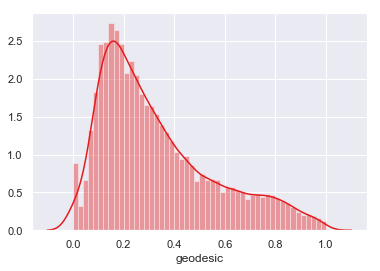

In [126]:
#Looking at distplot after normalization

sns.distplot(train['geodesic'],bins=50)
plt.savefig('distplot for geodesic after normalization.png')

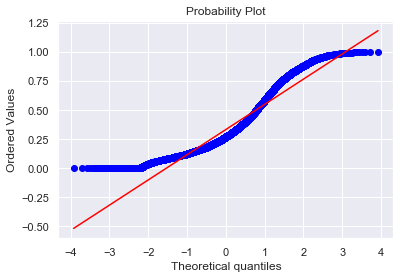

In [127]:
#Looking at QQ plot after normalization

plt.figure()
stats.probplot(train['geodesic'],dist='norm',fit=True,plot=plt)
plt.savefig('QQ plot for geodesic after normalization')

In [128]:
df4=train.copy()
train=df4.copy()
f4=test.copy()
test=f4.copy()

In [129]:
train=train.drop(['passenger_count_2'],axis=1)
test=test.drop(['passenger_count_2'],axis=1)

In [130]:
train.columns

Index(['fare_amount', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'seasons_spring',
       'seasons_summer', 'seasons_winter', 'week_weekend', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'geodesic'],
      dtype='object')

In [131]:
#Splitting into train and validation subsets
X = train.drop('fare_amount',axis=1).values
y = train[('fare_amount')].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 42)
print(train.shape,X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15660, 20) (11745, 19) (3915, 19) (11745,) (3915,)


In [132]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y,y_):
    print('r square',metrics.r2_score(y,y_))
    print('Adjusted r square ={}'.format(1 - (1 - metrics.r2_score(y,y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE ={}'.format(np.mean(np.abs((y - y_)/y))*100))
    print('MSE:',metrics.mean_squared_error(y,y_))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y,y_)))
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X_train)
    scores(y_train,y_pred)
    print('RMSLE:',rmsle(y_train,y_pred))
    print()
    print('<<<------------------- Test Data Score --------------------->')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(X_test)
    scores(y_test,y_pred)
    print('RMSLE:',rmsle(y_test,y_pred))   

In [133]:
#Setup the parametres and distributions to sample from : param.dist
param_dist = {'copy_X':[True, False],
          'fit_intercept':[True,False]}
# Instantiate a Decision reg classifier: reg
reg = LinearRegression()

# Instantiate the gridSearchCV object: reg_cv
reg_cv = GridSearchCV(reg, param_dist, cv=5,scoring='r2')

# Fit it to the data
reg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision reg Parameters: {}".format(reg_cv.best_params_))
print("Best score is {}".format(reg_cv.best_score_))

Tuned Decision reg Parameters: {'copy_X': True, 'fit_intercept': True}
Best score is 0.7352648429383517


R^2: 0.7417493736556626
Root Mean Squared Error: 2.30111474242634
<<<------------------- Training Data Score --------------------->

r square 0.734103727513075
Adjusted r square =0.7336728508241837
MAPE =18.747787141408825
MSE: 5.288462215937049
RMSE: 2.2996656748182005
RMSLE: 0.21667786304447972

<<<------------------- Test Data Score --------------------->

r square 0.7417493736556626
Adjusted r square =0.7404896145027634
MAPE =18.974578559344728
MSE: 5.295129057811841
RMSE: 2.30111474242634
RMSLE: 0.21557833431984733
[ 1.53955683e-01  2.24205308e-01  2.37789630e-01  2.18443424e-01
 -4.37101316e-01 -4.39982404e-01 -4.70141346e-01 -2.04659588e-01
 -4.01458075e-01 -4.55021169e-01 -6.72973963e-01 -7.89183745e-01
 -7.94564984e-02 -1.32066595e-02  4.33811703e-01  1.28834717e+00
  1.50693270e+00  1.74352424e+00  1.67346929e+01]


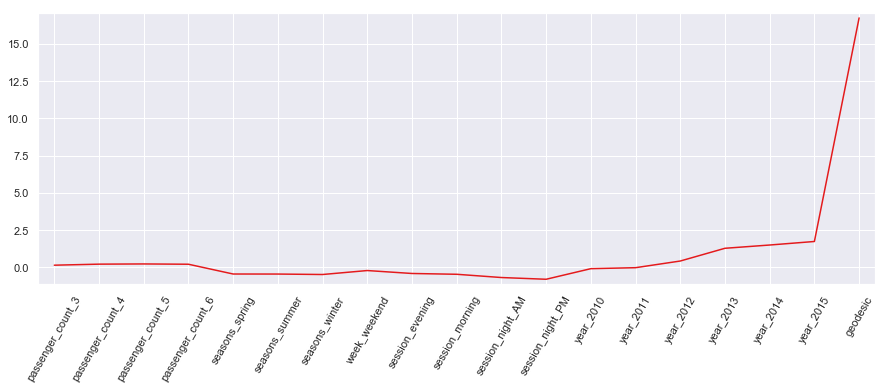

In [134]:
# Create the regressor: reg_all
reg_all = LinearRegression(copy_X= True, fit_intercept=True)

# Fit the regressor to the training data
reg_all.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
test_scores(reg_all)

# Compute and print the coefficients
reg_coef = reg_all.coef_
print(reg_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(test.columns)), reg_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('linear coefficients')
plt.show()

In [135]:
#create a linear regression object: reg
reg = LinearRegression()

#compute cross validation scores
cv_scores = cross_val_score(reg,X,y,cv=5,scoring='neg_mean_squared_error')

#print the scores
print(cv_scores)

print("Avg 5-Fold CV score: {}".format(np.mean(cv_scores)))



train.info()

[-5.31405842 -5.33992266 -5.11253273 -5.30738332 -5.43186727]
Avg 5-Fold CV score: -5.301152878860707
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15660 entries, 0 to 15660
Data columns (total 20 columns):
fare_amount          15660 non-null float64
passenger_count_3    15660 non-null category
passenger_count_4    15660 non-null category
passenger_count_5    15660 non-null category
passenger_count_6    15660 non-null category
seasons_spring       15660 non-null category
seasons_summer       15660 non-null category
seasons_winter       15660 non-null category
week_weekend         15660 non-null category
session_evening      15660 non-null category
session_morning      15660 non-null category
session_night_AM     15660 non-null category
session_night_PM     15660 non-null category
year_2010            15660 non-null category
year_2011            15660 non-null category
year_2012            15660 non-null category
year_2013            15660 non-null category
year_2014            1566

In [136]:
#Decision Tree
param_dist = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the gridSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 6, 'min_samples_split': 2}
Best score is 0.7321185699884047


[3.23836835e-04 0.00000000e+00 0.00000000e+00 6.64128905e-04
 1.61246642e-04 0.00000000e+00 1.01156978e-03 6.89336856e-04
 4.01832659e-04 0.00000000e+00 0.00000000e+00 7.14551424e-05
 5.12718861e-04 0.00000000e+00 3.63120743e-04 1.09784387e-02
 1.22157316e-02 9.80535721e-03 9.62801226e-01]


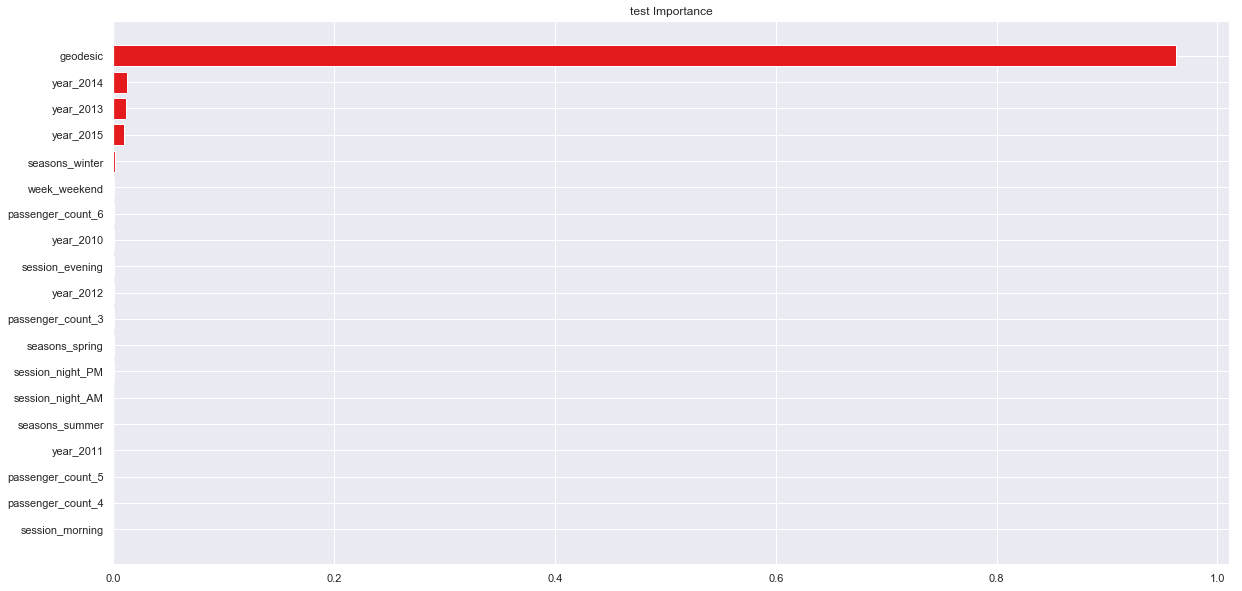

<<<------------------- Training Data Score --------------------->

r square 0.7462993015919626
Adjusted r square =0.7458881874538174
MAPE =18.556715830164173
MSE: 5.045902092342125
RMSE: 2.2463085478941056
RMSLE: 0.2090693362589056

<<<------------------- Test Data Score --------------------->

r square 0.7396688274047053
Adjusted r square =0.7383989192457039
MAPE =19.109140137206758
MSE: 5.33778824151069
RMSE: 2.3103653913419606
RMSLE: 0.212562309698269


In [137]:
# Instantiate a tree regressor: tree
tree = DecisionTreeRegressor(max_depth= 6, min_samples_split=2)

# Fit the regressor to the data
tree.fit(X_train,y_train)

# Compute and print the coefficients
tree_features = tree.feature_importances_
print(tree_features)

# Sort test importances in descending order
indices = np.argsort(tree_features)[::1]

# Rearrange test names so they match the sorted test importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("test Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),tree_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig('tree test importance')
plt.show()

# Make predictions and cal error
test_scores(tree)

In [138]:
#Random Forest Regression

# Create the random grid
random_grid = {'n_estimators': range(100,500,100),
               'max_depth': range(5,20,1),
               'min_samples_leaf':range(2,5,1),
              'max_features':['auto','sqrt','log2'],
              'bootstrap': [True, False],
              'min_samples_split': range(2,5,1)}
# Instantiate a Decision Forest classifier: Forest
Forest = RandomForestRegressor()

# Instantiate the gridSearchCV object: Forest_cv
Forest_cv = RandomizedSearchCV(Forest, random_grid, cv=5)

# Fit it to the data
Forest_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(Forest_cv.best_params_))
print("Best score is {}".format(Forest_cv.best_score_))


Tuned Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 8, 'bootstrap': True}
Best score is 0.7451053330375648


[1.07462903e-03 5.16966626e-04 7.10390917e-04 6.20571342e-04
 2.42084253e-03 2.48866957e-03 2.28356755e-03 3.24270807e-03
 2.59845306e-03 2.33151893e-03 2.25145213e-03 4.03716909e-03
 2.78376243e-03 9.30869277e-04 1.79765107e-03 1.04939073e-02
 1.21950443e-02 9.56218815e-03 9.37659639e-01]


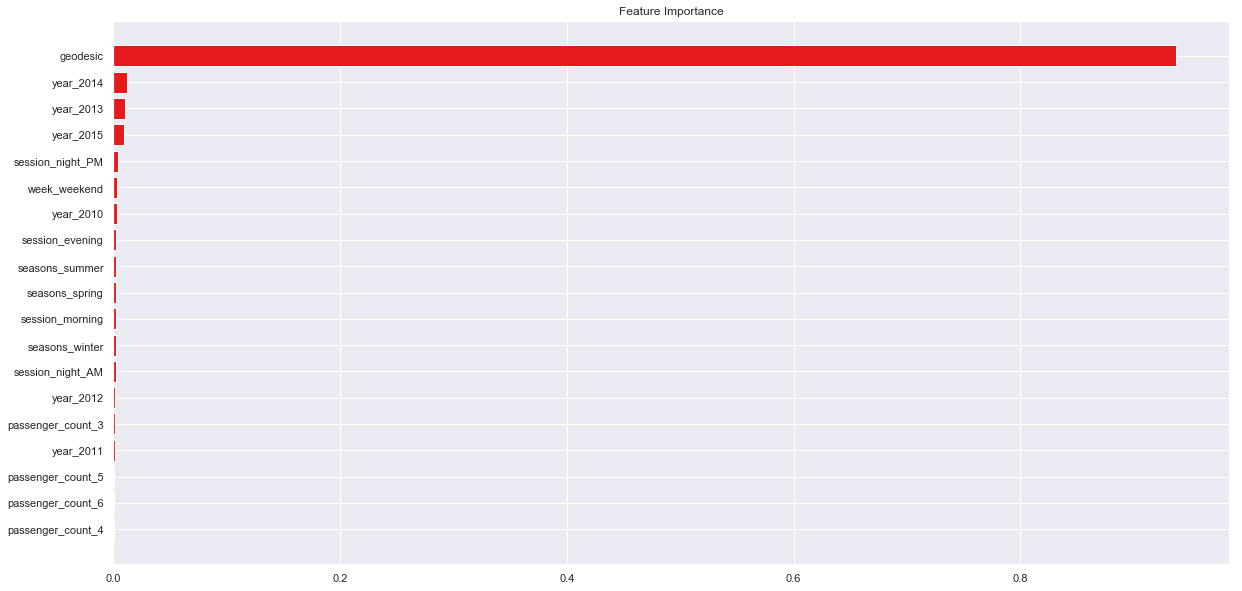

<<<------------------- Training Data Score --------------------->

r square 0.7891652495385809
Adjusted r square =0.7888235983438033
MAPE =16.99499626293475
MSE: 4.193332991069135
RMSE: 2.047762923550755
RMSLE: 0.19156665430259484

<<<------------------- Test Data Score --------------------->

r square 0.752130106523612
Adjusted r square =0.7509209850920199
MAPE =18.632826071263484
MSE: 5.082284190681992
RMSE: 2.2543921998361314
RMSLE: 0.20780181994147776


In [139]:
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor(n_estimators=100, min_samples_split= 2, min_samples_leaf=4, max_features='auto', max_depth=9, bootstrap=True)

# Fit the regressor to the data
Forest.fit(X_train,y_train)

# Compute and print the coefficients
Forest_features = Forest.feature_importances_
print(Forest_features)

# Sort feature importances in descending order
indices = np.argsort(Forest_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),Forest_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig('Random forest feature importance')
plt.show()# Make predictions
test_scores(Forest)

In [140]:

from sklearn.model_selection import cross_val_score
# Create a random forest regression object: Forest
Forest = RandomForestRegressor(n_estimators=400, min_samples_split= 2, min_samples_leaf=4, max_features='auto', max_depth=12, bootstrap=True)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(Forest,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-5.20422773 -5.1897744  -5.12125498 -5.14282019 -5.15890424]
Average 5-Fold CV Score: -5.1633963096731845


In [141]:
#Improving accuracy using XGBOOST
#This will require us to do wo things, a)Algorithim Tuning , b)Ensembling

data_dmatrix = xgb.DMatrix(data=X,label=y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [142]:
dtrain,dtest,data_dmatrix

(<xgboost.core.DMatrix at 0x22619d73a90>,
 <xgboost.core.DMatrix at 0x22619e307f0>)

In [143]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

[20:50:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,9.031684,0.018711,9.032080,0.078062
1,8.327162,0.017752,8.327621,0.078889
2,7.680679,0.049837,7.681947,0.117905
3,7.113785,0.104407,7.115897,0.164964
4,6.575033,0.115281,6.577276,0.134310


In [144]:
# the final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

49    2.503515
Name: test-rmse-mean, dtype: float64


In [145]:
Xgb = XGBRegressor()
Xgb.fit(X_train,y_train)
# pred_xgb = model_xgb.predict(X_test)
test_scores(Xgb)

[20:50:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<<<------------------- Training Data Score --------------------->

r square 0.7612267755928697
Adjusted r square =0.7608398509648325
MAPE =17.812795465613544
MSE: 4.7490066846148045
RMSE: 2.1792215776774064
RMSLE: 0.20089076447196702

<<<------------------- Test Data Score --------------------->

r square 0.7594388547462718
Adjusted r square =0.7582653857450341
MAPE =18.242458562653024
MSE: 4.93242679967441
RMSE: 2.2209067516837373
RMSLE: 0.20458699758537854


In [146]:
# Create the random grid
para = {'n_estimators': range(100,500,100),
               'max_depth': range(3,10,1),
        'reg_alpha':np.logspace(-4, 0, 50),
        'subsample': np.arange(0.1,1,0.2),
        'colsample_bytree': np.arange(0.1,1,0.2),
        'colsample_bylevel': np.arange(0.1,1,0.2),
        'colsample_bynode': np.arange(0.1,1,0.2),
       'learning_rate': np.arange(.05, 1, .05)}
# Instantiate a Decision Forest classifier: Forest
Xgb = XGBRegressor()

# Instantiate the gridSearchCV object: Forest_cv
xgb_cv = RandomizedSearchCV(Xgb, para, cv=5)

# Fit it to the data
xgb_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Xgboost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))

[20:50:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:51:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.0163672  0.02025543 0.01900181 0.0194276  0.02338376 0.01822098
 0.01947856 0.01803529 0.02463897 0.0196883  0.03037793 0.02787284
 0.0361837  0.02956132 0.03350323 0.05328882 0.04968937 0.04410567
 0.49691918]


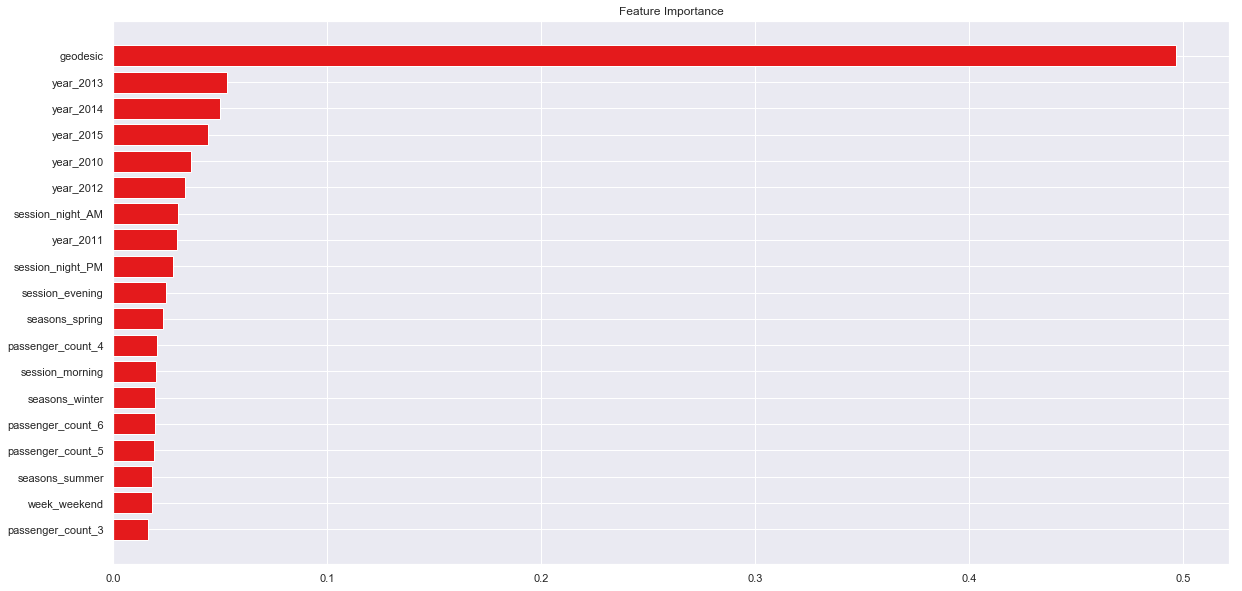

<<<------------------- Training Data Score --------------------->

r square 0.7538013230629036
Adjusted r square =0.7534023657186132
MAPE =18.046417450519538
MSE: 4.896692941265472
RMSE: 2.2128472476123315
RMSLE: 0.20442264427538773

<<<------------------- Test Data Score --------------------->

r square 0.7562363186757589
Adjusted r square =0.755047227547348
MAPE =18.394425576448693
MSE: 4.998091081096336
RMSE: 2.2356410895079595
RMSLE: 0.20597353947203217


In [147]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X_train,y_train)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig(' xgb feature importance')
plt.show()# Make predictions
test_scores(Xgb)

In [148]:
#Finalizing the model

def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def score(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_)))
    print('RMSLE:',rmsle(y_test,y_pred))
def scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X)
    score(y,y_pred)
    print('RMSLE:',rmsle(y,y_pred))

In [149]:
a=pd.read_csv('test.csv')

In [150]:
test_pickup_datetime=a['pickup_datetime']

[20:51:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.01549275 0.01744883 0.01348146 0.02059281 0.01613514 0.01553756
 0.01431016 0.01684589 0.01347196 0.01476288 0.0219787  0.01721968
 0.03212254 0.02565873 0.01648236 0.04182667 0.05398482 0.04004656
 0.5926005 ]


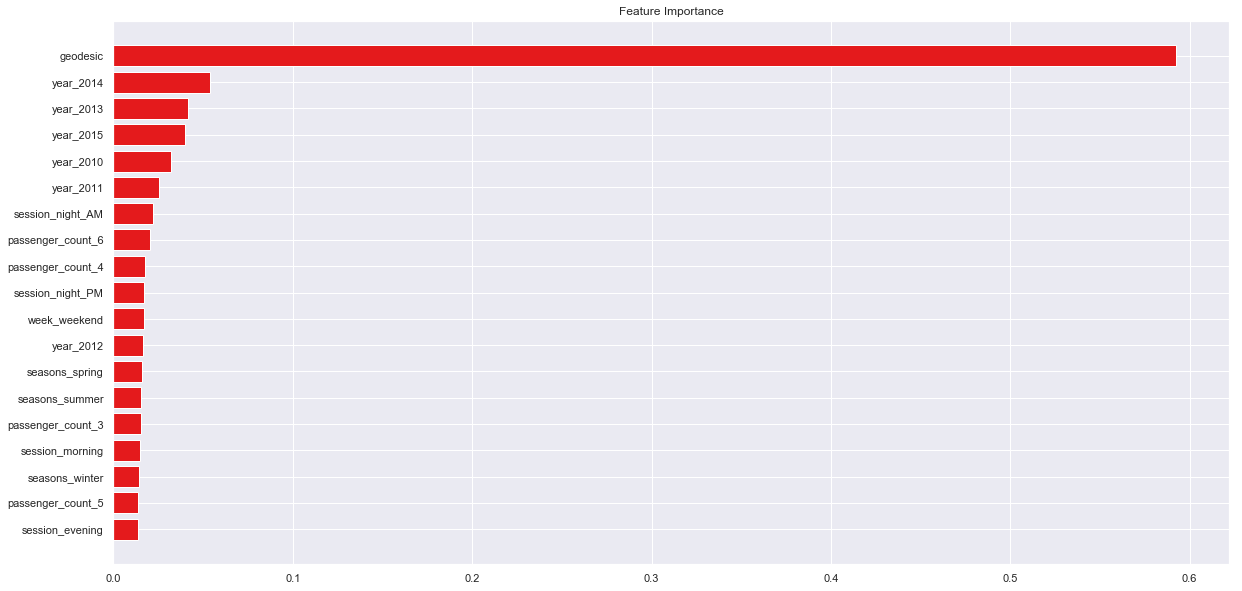

<<<------------------- Training Data Score --------------------->

r square   0.7551382855214605
Adjusted r square:0.7548408192442806
MAPE:18.226273042320482
MSE: 4.907758325104557
RMSE: 2.2153460960095055
RMSLE: 0.21557833431984733
RMSLE: 0.20480110751587735
<<<------------------- Training Data Score --------------------->

r square   0.7551382855214605
Adjusted r square:0.7548408192442806
MAPE:18.226273042320482
MSE: 4.907758325104557
RMSE: 2.2153460960095055
RMSLE: 0.21557833431984733
RMSLE: 0.20480110751587735


In [151]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X,y)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig(' xgb1 feature importance')
plt.show()
scores(Xgb)
scores(Xgb)

# Predictions
pred = Xgb.predict(test.values)
pred_results_wrt_date = pd.DataFrame({"pickup_datetime":test_pickup_datetime,"fare_amount" : pred})
pred_results_wrt_date.to_csv("predictions_xgboost.csv",index=False)

In [152]:
pred_results_wrt_date

,pickup_datetime,fare_amount
0,2015-01-27 13:08:24 UTC,6.615897
1,2015-01-27 13:08:24 UTC,6.615897
2,2011-10-08 11:53:44 UTC,4.933924
3,2012-12-01 21:12:12 UTC,5.143349
4,2012-12-01 21:12:12 UTC,4.330778
5,2012-12-01 21:12:12 UTC,4.788739
6,2011-10-06 12:10:20 UTC,5.583616
7,2011-10-06 12:10:20 UTC,6.988472
8,2011-10-06 12:10:20 UTC,4.653873
9,2014-02-18 15:22:20 UTC,6.384586


In [153]:
# Save the model as a pickle in a file 
joblib.dump(Xgb, 'cab_fare_xgboost_model.pkl')

['cab_fare_xgboost_model.pkl']